In [16]:
import numpy as np
import pandas as pd

def QNNs_gen(data,target_column,feature_column,save_path):
  import torch
  import torch.nn as nn
  import torch.optim as optim
  from torch.utils.data import DataLoader, TensorDataset
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import r2_score
  import joblib
  class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(32, output_size)

    def forward(self, x):
        # Forward pass records for optimization
        self.outputs = {}
        self.activations = {}

        z1 = self.layer1(x)
        self.activations['layer1'] = z1
        x = self.relu1(z1)

        z2 = self.layer2(x)
        self.activations['layer2'] = z2
        x = self.relu2(z2)

        z3 = self.layer3(x)
        self.activations['layer3'] = z3
        x = self.relu3(z3)

        out = self.output_layer(x)
        self.outputs['output'] = out
        return out
  def adjusted_quantile_loss(outputs, targets, quantile, lower_bound=None, upper_bound=None):
    errors = targets - outputs
    basic_loss = torch.max((quantile - 1) * errors, quantile * errors)
    loss = torch.mean(basic_loss)

    if lower_bound is not None:
        crossing_penalty = torch.mean(torch.relu(lower_bound - outputs))
        loss += crossing_penalty
    if upper_bound is not None:
        crossing_penalty = torch.mean(torch.relu(outputs - upper_bound))
        loss += crossing_penalty

    return loss
  features = data[feature_column]
  target = data[target_column]
  X = torch.tensor(features.values, dtype=torch.float32)
  y = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)
  scaler = StandardScaler()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
  X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

  # Initialize models and optimizers
  quantiles = [0.5, 0.75, 0.25, 0.9, 0.1, 0.95, 0.05,0.99,0.01]
  models = [NeuralNet(X_train.shape[1], 1) for _ in quantiles]
  optimizers = [optim.Adam(model.parameters(), lr=0.01) for model in models]

  # Store bounds for each quantile and input
  input_bounds = {q: {'lower': None, 'upper': None} for q in quantiles}



      # Training loop
  # Adjusted training loop
  for epoch in range(200):
      for inputs, labels in train_loader:
          current_outputs = {}  # Dictionary to store outputs for current batch

          # Clear gradients at the start of each batch
          for optimizer in optimizers:
              optimizer.zero_grad()

          first_pass = True  # Flag to handle retain_graph properly

          for q_idx, quantile in enumerate(quantiles):
              model = models[q_idx]
              outputs = model(inputs)
              current_outputs[quantile] = outputs.detach().clone()  # Detach and clone to avoid in-place modifications

              # Assign bounds based on quantile relationships
              lower_bound = None
              upper_bound = None
              if quantile == 0.75:
                  lower_bound = current_outputs.get(0.5)  # Lower bound from median
              elif quantile == 0.25:
                  upper_bound = current_outputs.get(0.5)  # Upper bound from median
              elif quantile == 0.9:
                  lower_bound = current_outputs.get(0.75)
              elif quantile == 0.1:
                  upper_bound = current_outputs.get(0.25)
              elif quantile == 0.95:
                  lower_bound = current_outputs.get(0.9)
              elif quantile == 0.05:
                  upper_bound = current_outputs.get(0.1)
              elif quantile == 0.99:
                lower_bound = current_outputs.get(0.95)
              elif quantile == 0.01:
                  upper_bound = current_outputs.get(0.05)

              # Adjusted quantile loss calculation
              loss = adjusted_quantile_loss(outputs, labels, quantile, lower_bound, upper_bound)
              loss.backward(retain_graph=first_pass)  # Only retain graph on the first backward pass

              first_pass = False  # Ensure subsequent passes do not retain graph
          for optimizer in optimizers:
              optimizer.step()

          # Optionally, clear dictionary to free memory after processing each batch
          current_outputs.clear()
  # Evaluation of models
  for i, model in enumerate(models):
      model.eval()
      with torch.no_grad():
          predictions_train = model(X_train)
          predictions_test = model(X_test)
          r2_train = r2_score(y_train.numpy(), predictions_train.numpy())
          r2_test = r2_score(y_test.numpy(), predictions_test.numpy())
          print(f'Quantile: {quantiles[i]}, Training R-squared: {r2_train:.4f}, Testing R-squared: {r2_test:.4f}')
  # After training all models, save each model's state
  joblib.dump(scaler, f'{save_path}scaler.pkl')
  for idx, model in enumerate(models):
      torch.save({
          'state_dict': model.state_dict(),
          'weights': [param.detach().numpy() for param in model.parameters()]
      }, f'{save_path}model_quantile_{quantiles[idx]}.pth')
    

  print("All models' states saved.")


Train of QNN

In [18]:
import numpy as np
import pandas as pd
#Load dataset
#Load dataset
file_path = '/Users/ansonkong/Downloads/QNN-test/p122_synthetic.csv'
data = pd.read_csv(file_path)
#Feature
feature_column=['battery_2#p122','gas-cc#p122','upv#p122','wind-ons#p122']
#target
target_column='value'
save_path="/Users/ansonkong/Downloads/QNN-test/"


QNNs_gen(data,target_column,feature_column,save_path)

Quantile: 0.5, Training R-squared: 0.8978, Testing R-squared: 0.9189
Quantile: 0.75, Training R-squared: 0.8884, Testing R-squared: 0.9088
Quantile: 0.25, Training R-squared: 0.8801, Testing R-squared: 0.9038
Quantile: 0.9, Training R-squared: 0.8472, Testing R-squared: 0.8666
Quantile: 0.1, Training R-squared: 0.8407, Testing R-squared: 0.8654
Quantile: 0.95, Training R-squared: 0.7866, Testing R-squared: 0.8045
Quantile: 0.05, Training R-squared: 0.8039, Testing R-squared: 0.8289
Quantile: 0.99, Training R-squared: 0.4293, Testing R-squared: 0.4391
Quantile: 0.01, Training R-squared: 0.7514, Testing R-squared: 0.7760
All models' states saved.


Use QNN bias and weight

In [11]:
import torch
import torch.nn as nn
import numpy as np
import joblib
import os

class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(32, output_size)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.relu3(self.layer3(x))
        return self.output_layer(x)

class QuantileModelPredictor:
    def __init__(self, model_directory):
        self.scaler = joblib.load(os.path.join(model_directory, 'scaler.pkl'))
        self.models = []
        self.weights = []
        self.biases = []

        quantiles = [ 0.01,0.1,0.25,0.5, 0.75, 0.9, 0.95, 0.99]
        for i, q in enumerate(quantiles):
            model_path = os.path.join(model_directory, f'model_quantile_{q}.pth')
            model_info = torch.load(model_path)
            model = NeuralNet(input_size=4, output_size=1)
            model.load_state_dict(model_info['state_dict'])
            model.eval()
            self.models.append(model)

            # Extract weights and biases
            model_weights = []
            model_biases = []
            for name, param in model.named_parameters():
                if 'weight' in name:
                    model_weights.append(param.detach().numpy())
                elif 'bias' in name:
                    model_biases.append(param.detach().numpy())
            self.weights.append(model_weights)
            self.biases.append(model_biases)

    def predict_quantiles(self, inputs):
        # Ensure inputs is a numpy array
        inputs = np.array(inputs).reshape(1, -1)  # Reshape if inputs is a single data point
        scaled_inputs = self.scaler.transform(inputs)

        outputs = []
        for i in range(len(self.models)):
            x = scaled_inputs
            for layer_weights, layer_biases in zip(self.weights[i], self.biases[i]):
                x = np.dot(x, layer_weights.T) + layer_biases
                x = np.maximum(0, x)  # ReLU activation
            outputs.append(x.flatten()[0])  # Assuming single output from the last layer
        return outputs

# Usage example:
model_directory = '/Users/ansonkong/Downloads/QNN-test'
predictor = QuantileModelPredictor(model_directory)
inputs = [6000, 6000, 6000, 6000]  # Example inputs
quantile_outputs = predictor.predict_quantiles(inputs)
print("Quantile predictions:", quantile_outputs)


Quantile predictions: [2800539169.0150905, 2873664774.318864, 2757152467.7068934, 3009167461.717475, 2675379028.171216, 3139593415.921247, 5862678000.253195, 2381329979.5990124]


Tester to compare the resutl if we actually calcualte it or it was ising the QNN model

Manual Computation Outputs: [2800539169.0150905, 2873664774.318864, 2757152467.7068934, 3009167461.717475, 2675379028.171216, 3139593415.921247, 5862678000.253195, 2381329979.5990124]
Neural Network Model Outputs: [2800539100.0, 2873664800.0, 2757152500.0, 3009167400.0, 2675379000.0, 3139593500.0, 5862678000.0, 2381330000.0]


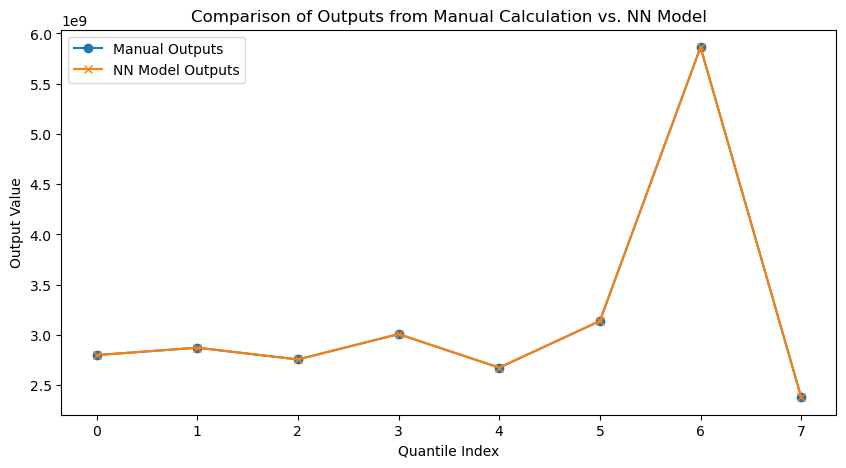

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class QuantileModelPredictor:
    def __init__(self, model_directory):
        self.scaler = joblib.load(os.path.join(model_directory, 'scaler.pkl'))
        self.models = []
        self.weights = []
        self.biases = []

        quantiles = [0.5, 0.75, 0.25, 0.9, 0.1, 0.95, 0.99, 0.01]
        for i, q in enumerate(quantiles):
            model_path = os.path.join(model_directory, f'model_quantile_{q}.pth')
            model_info = torch.load(model_path)
            model = NeuralNet(input_size=4, output_size=1)
            model.load_state_dict(model_info['state_dict'])
            model.eval()
            self.models.append(model)

            # Extract weights and biases
            model_weights = []
            model_biases = []
            for name, param in model.named_parameters():
                if 'weight' in name:
                    model_weights.append(param.detach().numpy())
                elif 'bias' in name:
                    model_biases.append(param.detach().numpy())
            self.weights.append(model_weights)
            self.biases.append(model_biases)

    def predict_quantiles(self, inputs):
        inputs = np.array(inputs).reshape(1, -1)  # Reshape if inputs is a single data point
        scaled_inputs = self.scaler.transform(inputs)

        manual_outputs = []
        nn_outputs = []
        for i, model in enumerate(self.models):
            # Manual forward pass
            x = scaled_inputs
            for layer_weights, layer_biases in zip(self.weights[i], self.biases[i]):
                x = np.dot(x, layer_weights.T) + layer_biases
                x = np.maximum(0, x)  # ReLU activation
            manual_outputs.append(x.flatten()[0])

            # Using the neural network model
            test_tensor = torch.tensor(scaled_inputs, dtype=torch.float32)
            with torch.no_grad():
                nn_output = model(test_tensor).numpy().flatten()[0]
            nn_outputs.append(nn_output)

        return manual_outputs, nn_outputs

# Usage example:
model_directory = '/Users/ansonkong/Downloads/QNN-test'
predictor = QuantileModelPredictor(model_directory)
inputs = [100, 200, 300, 400]  # Example inputs
manual_outputs, nn_outputs = predictor.predict_quantiles(inputs)

# Print or plot the comparison
print("Manual Computation Outputs:", manual_outputs)
print("Neural Network Model Outputs:", nn_outputs)

# Plotting the outputs for visual comparison
plt.figure(figsize=(10, 5))
plt.plot(manual_outputs, label='Manual Outputs', marker='o')
plt.plot(nn_outputs, label='NN Model Outputs', marker='x')
plt.title('Comparison of Outputs from Manual Calculation vs. NN Model')
plt.xlabel('Quantile Index')
plt.ylabel('Output Value')
plt.legend()


In [20]:
import pandas as pd
import numpy as np

def run_multiple_experiments(data, target_column, feature_column, save_path, num_runs=50):
    results = []
    for run in range(num_runs):
        print(f"Starting run {run + 1}/{num_runs}")
        result = QNNs_gen(data, target_column, feature_column, save_path)
        results.append(result)
    
    # Save the results to a CSV file
    quantiles = [0.5, 0.75, 0.25, 0.9, 0.1, 0.95, 0.05, 0.99, 0.01]
    df = pd.DataFrame(results, columns=quantiles)
    df.to_csv(f"{save_path}quantile_performance_numberofquantile{len(quantiles)}.csv", index=False)
    print("All runs completed and results saved to CSV.")

def QNNs_gen(data,target_column,feature_column,save_path):
  import torch
  import torch.nn as nn
  import torch.optim as optim
  from torch.utils.data import DataLoader, TensorDataset
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import r2_score
  import joblib
  class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(32, output_size)

    def forward(self, x):
        # Forward pass records for optimization
        self.outputs = {}
        self.activations = {}

        z1 = self.layer1(x)
        self.activations['layer1'] = z1
        x = self.relu1(z1)

        z2 = self.layer2(x)
        self.activations['layer2'] = z2
        x = self.relu2(z2)

        z3 = self.layer3(x)
        self.activations['layer3'] = z3
        x = self.relu3(z3)

        out = self.output_layer(x)
        self.outputs['output'] = out
        return out
  def adjusted_quantile_loss(outputs, targets, quantile, lower_bound=None, upper_bound=None):
    errors = targets - outputs
    basic_loss = torch.max((quantile - 1) * errors, quantile * errors)
    loss = torch.mean(basic_loss)

    if lower_bound is not None:
        crossing_penalty = torch.mean(torch.relu(lower_bound - outputs))
        loss += crossing_penalty
    if upper_bound is not None:
        crossing_penalty = torch.mean(torch.relu(outputs - upper_bound))
        loss += crossing_penalty

    return loss
  features = data[feature_column]
  target = data[target_column]
  X = torch.tensor(features.values, dtype=torch.float32)
  y = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)
  scaler = StandardScaler()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
  X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

  # Initialize models and optimizers
  quantiles = [0.5, 0.75, 0.25, 0.9, 0.1, 0.95, 0.05,0.99,0.01]
  models = [NeuralNet(X_train.shape[1], 1) for _ in quantiles]
  optimizers = [optim.Adam(model.parameters(), lr=0.01) for model in models]

  # Store bounds for each quantile and input
  input_bounds = {q: {'lower': None, 'upper': None} for q in quantiles}



      # Training loop
  # Adjusted training loop
  for epoch in range(200):
      for inputs, labels in train_loader:
          current_outputs = {}  # Dictionary to store outputs for current batch

          # Clear gradients at the start of each batch
          for optimizer in optimizers:
              optimizer.zero_grad()

          first_pass = True  # Flag to handle retain_graph properly

          for q_idx, quantile in enumerate(quantiles):
              model = models[q_idx]
              outputs = model(inputs)
              current_outputs[quantile] = outputs.detach().clone()  # Detach and clone to avoid in-place modifications

              # Assign bounds based on quantile relationships
              lower_bound = None
              upper_bound = None
              if quantile == 0.75:
                  lower_bound = current_outputs.get(0.5)  # Lower bound from median
              elif quantile == 0.25:
                  upper_bound = current_outputs.get(0.5)  # Upper bound from median
              elif quantile == 0.9:
                  lower_bound = current_outputs.get(0.75)
              elif quantile == 0.1:
                  upper_bound = current_outputs.get(0.25)
              elif quantile == 0.95:
                  lower_bound = current_outputs.get(0.9)
              elif quantile == 0.05:
                  upper_bound = current_outputs.get(0.1)
              elif quantile == 0.99:
                lower_bound = current_outputs.get(0.95)
              elif quantile == 0.01:
                  upper_bound = current_outputs.get(0.05)

              # Adjusted quantile loss calculation
              loss = adjusted_quantile_loss(outputs, labels, quantile, lower_bound, upper_bound)
              loss.backward(retain_graph=first_pass)  # Only retain graph on the first backward pass

              first_pass = False  # Ensure subsequent passes do not retain graph
          for optimizer in optimizers:
              optimizer.step()

          # Optionally, clear dictionary to free memory after processing each batch
          current_outputs.clear()
  # Evaluation of models
  all_rquare=[]
  for i, model in enumerate(models):
      model.eval()
      with torch.no_grad():
          predictions_train = model(X_train)
          predictions_test = model(X_test)
          r2_train = r2_score(y_train.numpy(), predictions_train.numpy())
          r2_test = r2_score(y_test.numpy(), predictions_test.numpy())
          all_rquare.append(r2_test)
          print(f'Quantile: {quantiles[i]}, Training R-squared: {r2_train:.4f}, Testing R-squared: {r2_test:.4f}')
  # After training all models, save each model's state
  joblib.dump(scaler, f'{save_path}scaler.pkl')
  for idx, model in enumerate(models):
      torch.save({
          'state_dict': model.state_dict(),
          'weights': [param.detach().numpy() for param in model.parameters()]
      }, f'{save_path}model_quantile_{quantiles[idx]}.pth')
    

  return all_rquare
file_path = '/Users/ansonkong/Downloads/QNN-test/p122_synthetic.csv'
data = pd.read_csv(file_path)
#Feature
feature_column=['battery_2#p122','gas-cc#p122','upv#p122','wind-ons#p122']
#target
target_column='value'
save_path="/Users/ansonkong/Downloads/QNN-test/"
# Example usage
data = pd.read_csv('/Users/ansonkong/Downloads/QNN-test/p122_synthetic.csv')  # Load your data
run_multiple_experiments(data, target_column, feature_column, '/Users/ansonkong/Downloads/QNN-test/')


Starting run 1/50
Quantile: 0.5, Training R-squared: 0.9140, Testing R-squared: 0.8556
Quantile: 0.75, Training R-squared: 0.9030, Testing R-squared: 0.8469
Quantile: 0.25, Training R-squared: -2.4875, Testing R-squared: -2.2333
Quantile: 0.9, Training R-squared: 0.8583, Testing R-squared: 0.8073
Quantile: 0.1, Training R-squared: -2.4875, Testing R-squared: -2.2333
Quantile: 0.95, Training R-squared: 0.8090, Testing R-squared: 0.7658
Quantile: 0.05, Training R-squared: -2.4875, Testing R-squared: -2.2333
Quantile: 0.99, Training R-squared: 0.1688, Testing R-squared: 0.2088
Quantile: 0.01, Training R-squared: -2.4875, Testing R-squared: -2.2333
Starting run 2/50
Quantile: 0.5, Training R-squared: 0.9340, Testing R-squared: 0.8008
Quantile: 0.75, Training R-squared: 0.9214, Testing R-squared: 0.7916
Quantile: 0.25, Training R-squared: 0.9126, Testing R-squared: 0.7832
Quantile: 0.9, Training R-squared: 0.8776, Testing R-squared: 0.7595
Quantile: 0.1, Training R-squared: 0.8805, Testing 